## DAS data processing demo

Provided by [Bin Luo](mailto:luob@sustech.edu.cn) and Qipeng Bai

This notebook demo provides a simple example of reading DAS data of various formats. It also provides basic signal processing steps to handle the data, such as trimming, concatenating, detrending, common-mode noise removal, tapering, filtering, and downsamping. 

## Conda environmental  

conda create -n dastools python=3.10

conda activate dastools

requirements:  
 - h5py==2.10.0
 - nptdms==1.6.0
 - numpy==1.18.5
 - scipy==1.5.0
 - segyio==1.9.9

conda install numpy scipy h5py nptdms segyio

conda install -n dastools ipykernel --update-deps --force-reinstall


In [ ]:
# !pip install -r requirements.txt

### Download DAS data examples from public data repositories

#### RAPID  (784M) hdf5
```
wget -c http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/ReceiveFiber/North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz-ReceiveFiber_2021-11-05T07_31_00-0700/North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz-ReceiveFiber_2021-11-05T143211Z.h5
```

#### PoroTomo  (44.0M) segy
```
wget -c https://nrel-pds-porotomo.s3.amazonaws.com/DAS/SEG-Y/DASV/20160317/PoroTomo_iDAS025_160318160317.sgy
```

#### FORGE 2C (278.44) tdms
```
wget -c https://constantine.seis.utah.edu/files/get_silixa_raw_tdms_april_2022.sh

bash get_silixa_raw_tdms_april_2022.sh
# wget -c https://pando-rgw01.chpc.utah.edu/silixa_das_raw_tdms_apr_2022/FORGE_DFIT_UTC_20220416_163041.202.tdms

```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DasTools import DasPrep as dp

In [24]:
metadata_h5 = dp.read_das('./data/North-C2-HF-P1kHz-GL30m-Sp2m-FS500Hz_2021-11-03T082931Z.h5', metadata=True)

for key in metadata_h5.keys():
    print(key, ':', metadata_h5[key])

dt : 0.004
nt : 15000
dx : 2.0419047
nch : 32600
GL : 30.628572
headers : {'AcquisitionId': b'89c88658-cb76-4a1a-bd85-b8e1572e49f5', 'GaugeLength': 30.628572, 'GaugeLengthUnit': b'm', 'MaximumFrequency': 250.0, 'MinimumFrequency': 0.0, 'NumberOfLoci': 32600, 'PulseRate': 1000.0, 'PulseWidth': 150.0, 'PulseWidthUnit': b'ns', 'SpatialSamplingInterval': 2.0419047, 'SpatialSamplingIntervalUnit': b'm', 'StartLocusIndex': 0, 'TriggeredMeasurement': b'false', 'VendorCode': b'OptaSense IU Setup 1.7.3 c5bde49175ee6dc70c95d4b39db648d3fda54a46', 'schemaVersion': b'2.0', 'uuid': b'89c88658-cb76-4a1a-bd85-b8e1572e49f5'}


In [28]:
metadata_segy = das.read_das('../Data/PoroTomo_iDAS025_160318160317.sgy', metadata=True)
data_segy = das.read_das('../Data/PoroTomo_iDAS025_160318160317.sgy')
print(metadata_segy)

{'dt': 0.001, 'nt': 30000, 'nch': 384}


In [8]:
!wget -c https://pando-rgw01.chpc.utah.edu/silixa_das_raw_tdms_apr_2022/FORGE_DFIT_UTC_20220416_163041.202.tdms

--2022-10-27 10:35:57--  https://pando-rgw01.chpc.utah.edu/silixa_das_raw_tdms_apr_2022/FORGE_DFIT_UTC_20220416_163041.202.tdms
Resolving pando-rgw01.chpc.utah.edu (pando-rgw01.chpc.utah.edu)... 155.101.11.35
Connecting to pando-rgw01.chpc.utah.edu (pando-rgw01.chpc.utah.edu)|155.101.11.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291962880 (278M) [application/octet-stream]
Saving to: ‘FORGE_DFIT_UTC_20220416_163041.202.tdms’

DFIT_UTC_20220416_1  24%[===>                ]  67.04M   293KB/s    eta 12m 23s^C


In [9]:
!wget -c https://nrel-pds-porotomo.s3.amazonaws.com/DAS/SEG-Y/DASV/20160317/PoroTomo_iDAS025_160318160317.sgy

--2022-10-27 10:40:02--  https://nrel-pds-porotomo.s3.amazonaws.com/DAS/SEG-Y/DASV/20160317/PoroTomo_iDAS025_160318160317.sgy
Resolving nrel-pds-porotomo.s3.amazonaws.com (nrel-pds-porotomo.s3.amazonaws.com)... 52.92.164.113, 52.218.225.123, 52.218.242.219, ...
Connecting to nrel-pds-porotomo.s3.amazonaws.com (nrel-pds-porotomo.s3.amazonaws.com)|52.92.164.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46175760 (44M) [binary/octet-stream]
Saving to: ‘PoroTomo_iDAS025_160318160317.sgy’

mo_iDAS025_16031816  15%[==>                 ]   6.95M  57.8KB/s    eta 7m 41s ^C


In [48]:
!wget -c https://nrel-pds-porotomo.s3.amazonaws.com/DAS/SEG-Y/DASH/20160321/PoroTomo_iDAS16043_160321073721.sgy


--2022-10-27 15:26:55--  https://nrel-pds-porotomo.s3.amazonaws.com/DAS/SEG-Y/DASH/20160321/PoroTomo_iDAS16043_160321073721.sgy
Resolving nrel-pds-porotomo.s3.amazonaws.com (nrel-pds-porotomo.s3.amazonaws.com)... 52.218.200.82, 52.218.235.91, 52.92.132.129, ...
Connecting to nrel-pds-porotomo.s3.amazonaws.com (nrel-pds-porotomo.s3.amazonaws.com)|52.218.200.82|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1048616640 (1000M), 155534142 (148M) remaining [binary/octet-stream]
Saving to: ‘PoroTomo_iDAS16043_160321073721.sgy’

PoroTomo_iDAS16043_ 100%[+++++++++++++++++==>]   1000M   132KB/s    in 26m 4s  

2022-10-27 15:53:00 (97.1 KB/s) - ‘PoroTomo_iDAS16043_160321073721.sgy’ saved [1048616640/1048616640]



In [17]:
!wget -c https://nrel-pds-porotomo.s3.amazonaws.com/DAS/H5/DASV/20160317/PoroTomo_iDAS025_160318160317.h5

--2022-10-28 11:44:48--  https://nrel-pds-porotomo.s3.amazonaws.com/DAS/H5/DASV/20160317/PoroTomo_iDAS025_160318160317.h5
Resolving nrel-pds-porotomo.s3.amazonaws.com (nrel-pds-porotomo.s3.amazonaws.com)... 52.218.242.227, 52.92.209.169, 52.92.147.41, ...
Connecting to nrel-pds-porotomo.s3.amazonaws.com (nrel-pds-porotomo.s3.amazonaws.com)|52.218.242.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46590272 (44M) [binary/octet-stream]
Saving to: ‘PoroTomo_iDAS025_160318160317.h5’

PoroTomo_iDAS025_16 100%[===================>]  44.43M  6.08MB/s    in 26s     

2022-10-28 11:45:16 (1.68 MB/s) - ‘PoroTomo_iDAS025_160318160317.h5’ saved [46590272/46590272]



### Read metadata from the data file

In [3]:
# metadata_tdms = dp.read_das('./FORGE_DFIT_UTC_20220416_163041.202.tdms', metadata=True)

# data_tdms = das.read_das('../Data/FORGE_DFIT_UTC_20220416_163041.202.tdms')

# metadata_tdms = dp.read_das('./PoroTomo_iDAS025_160321073717.sgy', metadata=True)
# metadata_tdms = dp.read_das('./PoroTomo_iDAS16043_160321073721.sgy', metadata=True)

metadata_tdms = dp.read_das('./FORGE_DFIT_UTC_20220416_163041.202.tdms', metadata=True)

for key in metadata_tdms.keys():
    print(key, ':', metadata_tdms[key])

[nptdms.tdms_segment WARNING] Data size 291840000 is not a multiple of the chunk size 1050624. Will attempt to read last chunk


dt : 0.00025
nt : 60000
dx : 1.0
nch : 2432
GL : 10.209523838714073
headers : OrderedDict([('name', 'FORGE_DFIT_UTC_20220416_163041.202'), ('SamplingFrequency[Hz]', 4000.0), ('SpatialResolution[m]', 1.0), ('Fibre Type', 'Constellation'), ('Zone Type', 'Single-Zone'), ('Start Distance (m)', 999.767622), ('Stop Distance (m)', 3481.702867), ('StreamTime[s]', inf), ('Continuous Mode', True), ('StartPosition[m]', 1.0), ('MeasureLength[m]', 2432), ('Zone Setup', False), ('Precise Sampling Frequency (Hz)', 20000.0), ('Zones', ''), ('Power Decrement', 0.0), ('Source Mode', 'Normal'), ('PeakVoltage[V]', 2.0), ('Pulse 2 Delay (ns)', 40.0), ('PulseWidth[ns]', 140.0), ('OffsetLength', 64.0), ('PreTrigSamples', 64), ('Reference length', 1), ('SavingBandwidth (MB/s)', 350.0), ('Reference Level 1', 65535), ('Reference Level 2', 56044), ('Reference Level 3', 48759), ('FibreIndex', 1.4682), ('Fibre Length Multiplier', 1.0209523838714072), ('UserZeroRef', 0.0), ('Unit Calibration (nm)', 116.0), ('Diff A

In [4]:
metadata_segy = dp.read_das('./PoroTomo_iDAS025_160321073717.sgy', metadata=True)

for key in metadata_segy.keys():
    print(key, ':', metadata_segy[key])

dt : 0.001
nt : 30000
nch : 384


In [13]:
from obspy.io.segy.core import _read_segy
st = _read_segy('./PoroTomo_iDAS025_160321073717.sgy')

In [16]:
st[0].stats

         network: 
         station: 
        location: 
         channel: 
       starttime: 2016-03-21T07:37:17.000000Z
         endtime: 2016-03-21T07:37:46.999000Z
   sampling_rate: 1000.0
           delta: 0.001
            npts: 30000
           calib: 1.0
            segy: AttribDict({'trace_header': LazyTraceHeaderAttribDict({'unpacked_header': b'\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfc\x18\xff\x9c\x00\x00\x00\x00\x00\x00\x00\x00\x01\xf4m\xfa\x1aEe&\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00u0\x03\xe8\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\xe0\x00Q\x00\x07\x00%\x00\x11\x0

In [12]:
import segyio
with segyio.open('./PoroTomo_iDAS025_160321073717.sgy', ignore_geometry=True) as segy_file:
    print(segy_file.attributes(field=segyio.TraceField))

TypeError: an integer is required (got type type)

In [18]:
metadata_h5 = dp.read_das('./PoroTomo_iDAS025_160318160317.h5', metadata=True)

for key in metadata_h5.keys():
    print(key, ':', metadata_h5[key])

KeyError: "Unable to open object (object 'Acquisition' doesn't exist)"

In [22]:
import h5py
f = h5py.File('./PoroTomo_iDAS025_160318160317.h5', 'r')
print(f.keys())

<KeysViewHDF5 ['channel', 'crs', 'das', 't', 'trace', 'x', 'y', 'z']>


### Read DAS raw data from the data file

In [50]:
%%time
# data = dp.read_das('./FORGE_DFIT_UTC_20220416_163041.202.tdms')

data = dp.read_das('./PoroTomo_iDAS16043_160321073721.sgy')

CPU times: user 194 ms, sys: 705 ms, total: 899 ms
Wall time: 1.15 s


### Check data size

In [51]:
# data shape convention: (number of channels, number of time samples)
data.shape

(8721, 30000)

### Preview the raw data

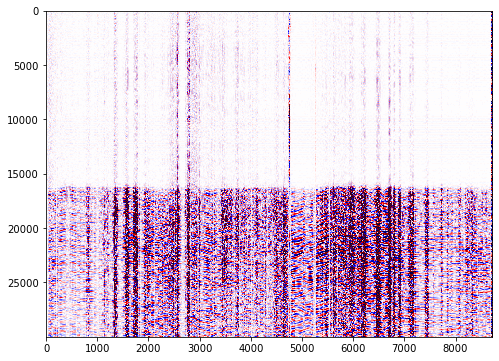

In [52]:
plt.figure(figsize=[8,6])

data_plot = data[:, :]
clim = data_plot.std() 
plt.imshow(data_plot.T, aspect='auto', cmap='seismic', vmin=-clim, vmax=clim)

### Detrend data, remove common-mode noise, and preview

In [53]:
# preprocessing / common-mode noise removal
data1 = dp.das_preprocess(data)

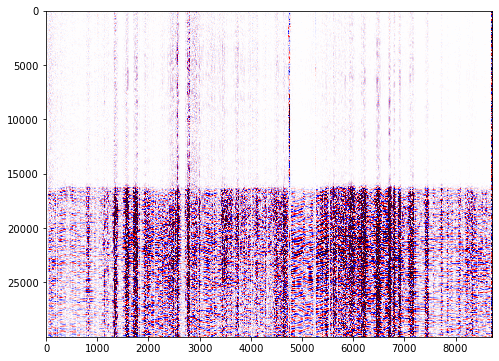

In [54]:
plt.figure(figsize=[8,6])

data_plot = data1[:, :]
clim = data_plot.std() 
plt.imshow(data_plot.T, aspect='auto', cmap='seismic', vmin=-clim, vmax=clim)

### Filter data and preview

In [55]:
# data filtering (channel-by-channel)
dt = metadata_tdms['dt']
data2 = dp.tapering(data1, 0.2)
data2 = dp.highpass(data2, dt, fl=1)

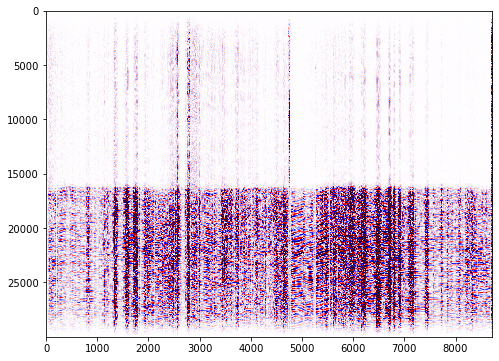

In [56]:
plt.figure(figsize=[8,6])

data_plot = data2[:, :]
clim = data_plot.std() 
plt.imshow(data_plot.T, aspect='auto', cmap='seismic', vmin=-clim, vmax=clim)

In [ ]:
# plot 

# image / seismic section / profile / 2D record

In [ ]:
# spectrogram / FFT / FK 

In [ ]:
# spatial variation

In [ ]:
# obspy beamforming 

In [ ]:
# event extraction

In [ ]:
# other packages LBL / Nate Lindsey??

In [ ]:
##    modeling 



#    CPS das modeling 
# madagascar  ewefd2d